In [1]:
import pandas as pd
import xarray as xr
from glob import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
import sys

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)


from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *

In [2]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1 = create_phi_bins_columns(df1)
df2 = create_phi_bins_columns(df2)

df1r = pd.read_parquet("../results/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

In [3]:
k_values = get_k_values(df1r, "k_values")

In [4]:
df1_rg, df1r_rg, df1w_rg = create_dfs_from_phi_interval('[0, 1)', df1, df1r, df1w)
df2_rg, df2r_rg, df2w_rg = create_dfs_from_phi_interval('[0, 1)', df2, df2r, df2w)

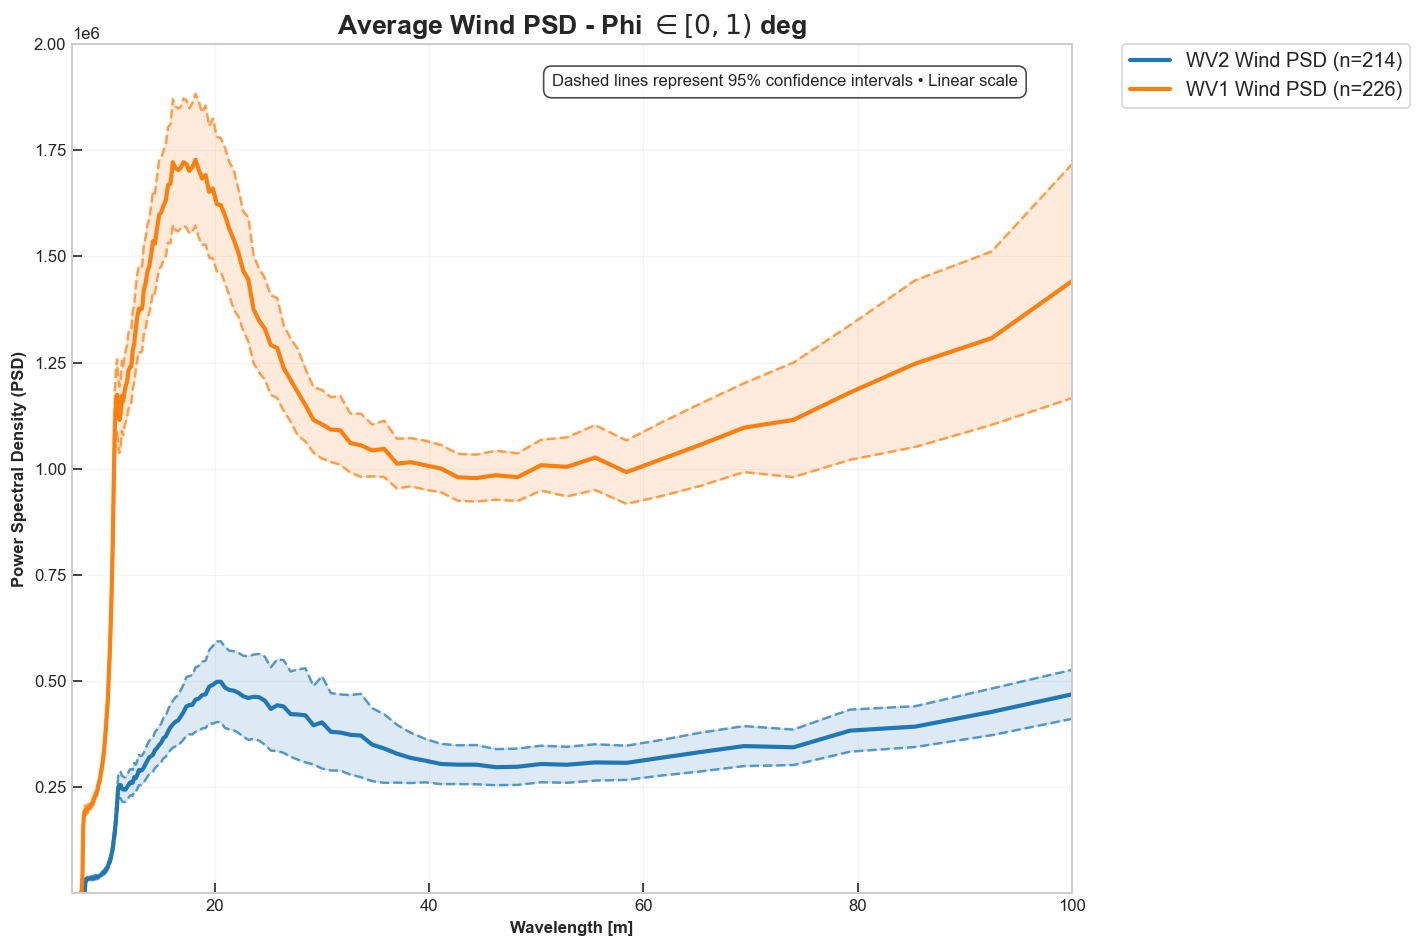

In [5]:
plot_avg_spectral_density(k_values, [df2w_rg, df1w_rg], ["WV2 Wind PSD", "WV1 Wind PSD"], 
                          "Average Wind PSD - Phi $\in [0,1)$ deg", 
                          x_range=(0.01, 0.15), y_range=(1, 0.2e7), 
                          use_log_scale=False, wavelength=True);

In [7]:
df1_az, df1r_az, df1w_az = create_dfs_from_phi_interval('[-90, -89)', df1, df1r, df1w)
df2_az, df2r_az, df2w_az = create_dfs_from_phi_interval('[-90, -89)', df2, df2r, df2w)

In [8]:
df1_rg2, df1r_rg2, df1w_rg2 = create_dfs_from_phi_interval('[-180, -179)', df1, df1r, df1w)
df2_rg2, df2r_rg2, df2w_rg2 = create_dfs_from_phi_interval('[-180, -179)', df2, df2r, df2w)

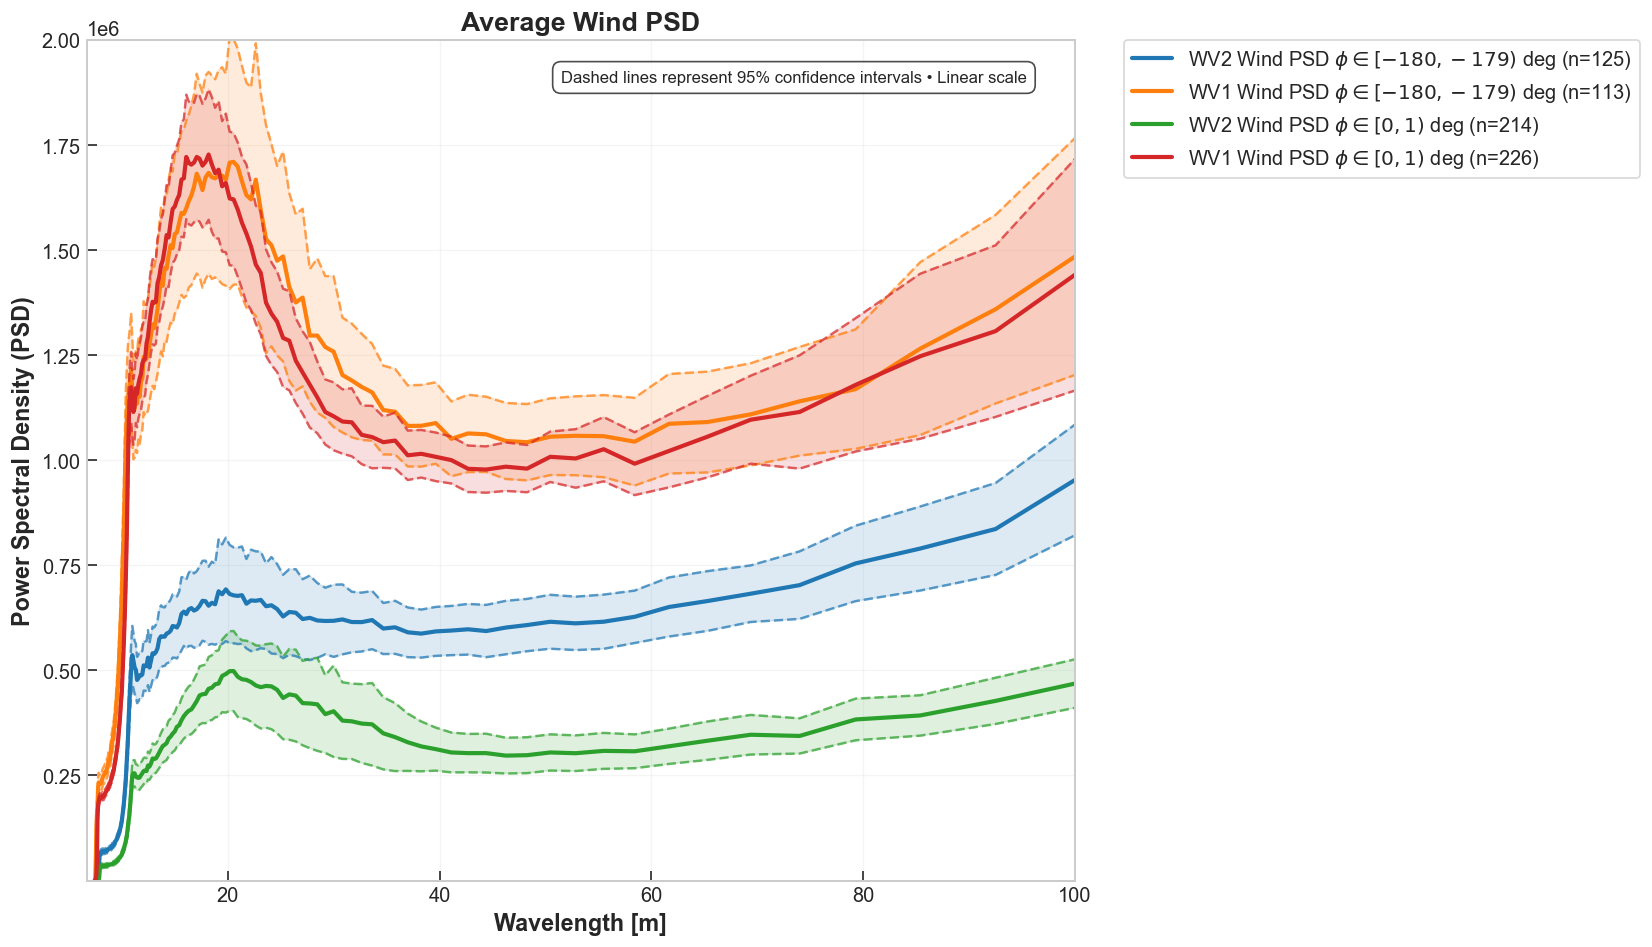

In [9]:
plot_avg_spectral_density(k_values, [df2w_rg2, df1w_rg2, df2w_rg, df1w_rg], ["WV2 Wind PSD $\\phi \\in [-180, -179)$ deg", 
                                                                             "WV1 Wind PSD $\\phi \\in [-180, -179)$ deg", 
                                                                             "WV2 Wind PSD $\\phi \\in [0, 1)$ deg", 
                                                                             "WV1 Wind PSD $\\phi \\in [0, 1)$ deg"],
                          "Average Wind PSD", 
                          x_range=(0.01, 0.15), y_range=(1, 0.2e7), 
                          use_log_scale=False, wavelength=True, figsize=(14, 8));

In [16]:
df1_rg.class_1.value_counts(), df2_rg.class_1.value_counts(), df1_rg2.class_1.value_counts()

(class_1
 POS    212
 SI       8
 AF       4
 IB       2
 Name: count, dtype: int64,
 class_1
 POS    195
 LWA      8
 SI       5
 AF       4
 WS       1
 IB       1
 Name: count, dtype: int64,
 class_1
 POS    103
 SI       6
 AF       3
 IB       1
 Name: count, dtype: int64)

In [24]:
df1_rg[['sst', 'airt', 'rh', 'blh']].describe()

,sst,airt,rh,blh
count,226.000000,226.000000,226.000000,226.000000
mean,7.784587,5.535162,74.196413,1589.136199
std,6.169372,6.600748,7.923435,279.147420
min,-1.690277,-15.621796,51.179268,681.093900
25%,2.942474,1.408699,68.814740,1424.718050
50%,7.036408,4.857910,74.636800,1601.195700
75%,11.148895,9.190270,79.892939,1771.014875
max,25.551422,24.098510,93.082886,2429.315400


In [ ]:


filtered_df1 = filter_similar_atmospheric_conditions(
    df1_rg, 
    air_sea_temp_diff_range=(-3, -1),  # Air 1-3°C colder than sea
    blh_range=(1400, 1600),            # BLH between 1400-1600m
    rh_range=(70, 80)                  # RH between 70-80%
)

filtered_df2 = filter_similar_atmospheric_conditions(
    df2_rg, 
    air_sea_temp_diff_range=(-3, -1),  # Air 1-3°C colder than sea
    blh_range=(1400, 1600),            # BLH between 1400-1600m
    rh_range=(70, 80)                  # RH between 70-80%
)

Filtered from 226 to 22 observations (9.7% retained)

Mean values before filtering:
Air-Sea Diff: -2.25°C, BLH: 1589m, RH: 74.2%

Mean values after filtering:
Air-Sea Diff: -1.61°C, BLH: 1498m, RH: 74.8%
Filtered from 214 to 13 observations (6.1% retained)

Mean values before filtering:
Air-Sea Diff: -2.37°C, BLH: 1620m, RH: 73.0%

Mean values after filtering:
Air-Sea Diff: -1.82°C, BLH: 1523m, RH: 75.1%


In [30]:
filtered_df1r = df1r[df1r['renamed_filename'].isin(filtered_df1['renamed_filename'])]
filtered_df2r = df2r[df2r['renamed_filename'].isin(filtered_df2['renamed_filename'])]

filtered_df1w = df1w[df1w['renamed_filename'].isin(filtered_df1['renamed_filename'])]
filtered_df2w = df2w[df2w['renamed_filename'].isin(filtered_df2['renamed_filename'])]

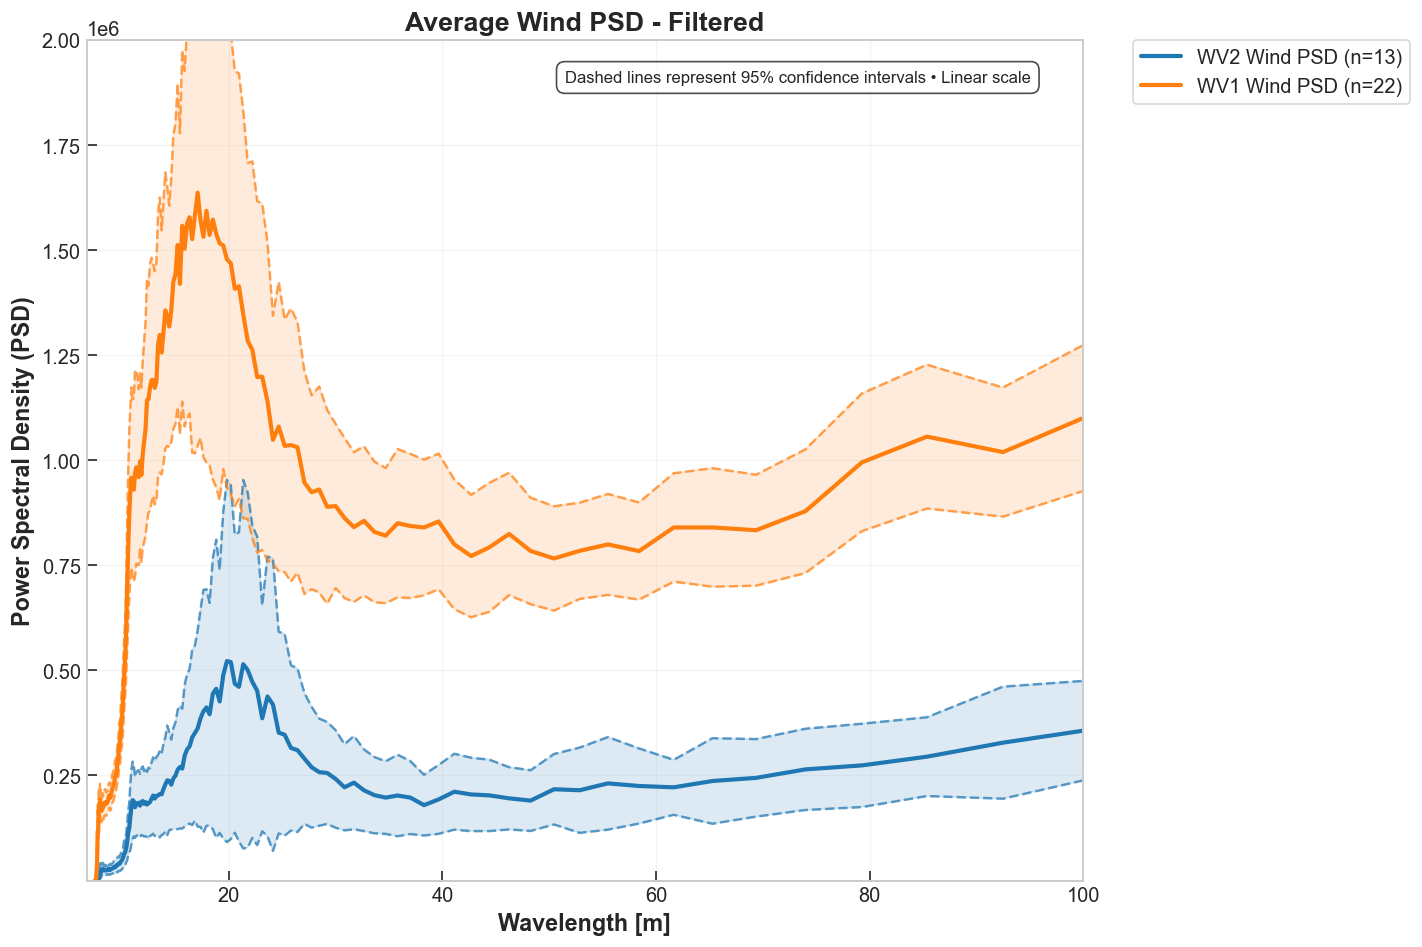

In [31]:
plot_avg_spectral_density(k_values, [filtered_df2w, filtered_df1w], ["WV2 Wind PSD", "WV1 Wind PSD"],
                          "Average Wind PSD - Filtered", 
                          x_range=(0.01, 0.15), y_range=(1, 0.2e7), 
                          use_log_scale=False, wavelength=True);